In [1]:
! pip install diffusers

In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler,UNet2DModel
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
dataset = torchvision.datasets.MNIST(root='/mnist',train=True,download=True,transform=torchvision.transforms.ToTensor())


In [4]:
train_dataloader = DataLoader(dataset,batch_size=64,shuffle=True)


torch.Size([64, 1, 28, 28]) torch.Size([64])


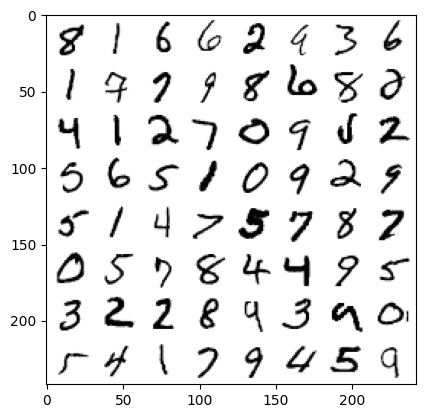

In [5]:
x,y = next(iter(train_dataloader))
print(x.shape,y.shape)
plt.imshow(torchvision.utils.make_grid(x)[0],cmap='Greys')


# Corruption process

noise = torch.rand_like(x)

noisy_x = (1-amount)*x + amount * noise

if amount = 0 we get back the original input

In [6]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

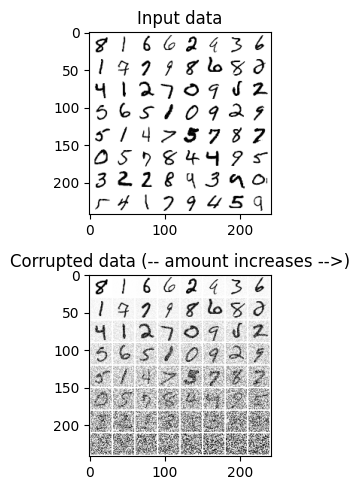

In [8]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');
plt.tight_layout()

In [9]:
class BasicUNet(nn.Module):
    def __init__(self,in_channels=1,out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels,32,kernel_size=5,padding=2),
            nn.Conv2d(32,64,kernel_size=5,padding=2),
            nn.Conv2d(64,64,kernel_size=5,padding=2)
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64,64,kernel_size=5,padding=2),
            nn.Conv2d(64,32,kernel_size=5,padding=2),
            nn.Conv2d(32,out_channels,kernel_size=5,padding=2)
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.up_scale = nn.Upsample(scale_factor=2)

    def forward(self,x):
        h = []
        for i,l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        for i,l in enumerate(self.up_layers):
            if i > 0:
                x = self.up_scale(x)
                x += h.pop()
            x = self.act(l(x))

        return x

In [12]:
net = BasicUNet().to(device)
x = torch.rand(8,1,28,28).to(device)
net(x).shape

torch.Size([8, 1, 28, 28])

In [13]:
sum([p.numel() for p in net.parameters()])

309057

Finished epoch 0 Avg loss for this epoch 0.017846
Finished epoch 1 Avg loss for this epoch 0.017016
Finished epoch 2 Avg loss for this epoch 0.016623


(0.0, 0.1)

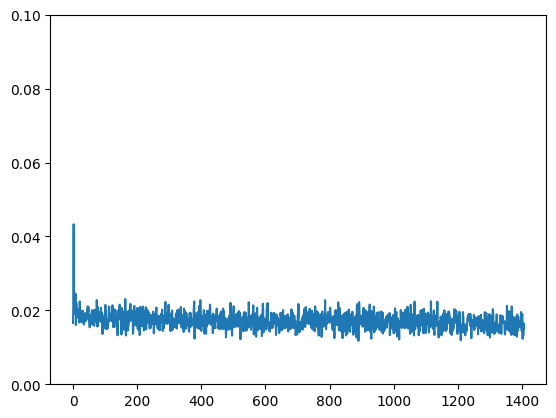

In [21]:
batch_size = 128
train_dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

n_epochs = 3

losses = []

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(),lr=1e-3)

losses = []
for epoch in range(n_epochs):
    for x,y in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x,noise_amount)

        pred = net(noisy_x)

        loss = loss_fn(pred,x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f"Finished epoch {epoch} Avg loss for this epoch {avg_loss:05f}")

plt.plot(losses)
plt.ylim(0,0.1)

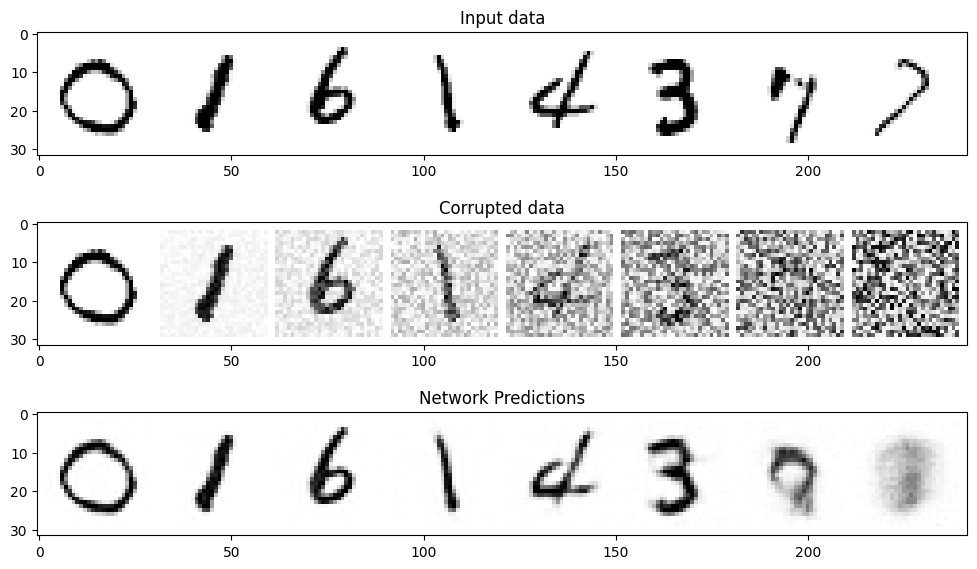

In [24]:
x,y = next(iter(train_dataloader))
x = x[:8]

amount = torch.linspace(0,1,x.shape[0])
noised_x = corrupt(x,amount)


with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

fig,axs = plt.subplots(3,1,figsize=(12,7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

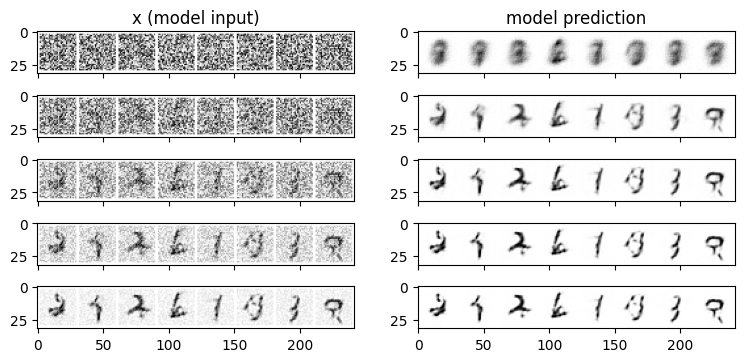

In [25]:
 n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

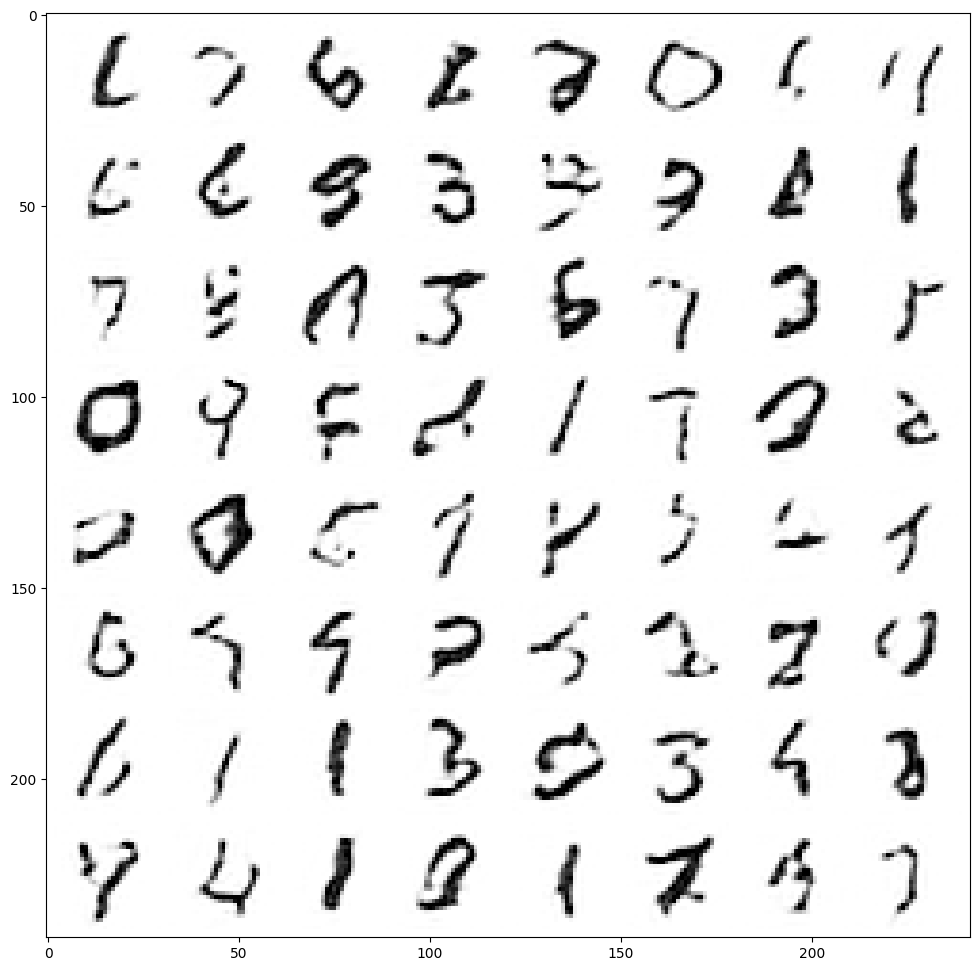

In [26]:
 n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')